In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
from timeit import default_timer as timer

In [2]:
import igraph

In [3]:
# %load ticart.py
import tigraphs as tig
import numpy as np
import igraph as ig


from itertools import combinations
from math import log, floor

class DecisionNode(tig.BasicNode,object):
    def __init__(self, **kwargs):
        super(DecisionNode, self).__init__(**kwargs)
        self.left=None
        self.right=None
        self.children=None
        self.parent=None
        self.prediction=None
        self.predicted_class=None
        self.tally={}
        self.total=0.0
        self.size=0
        self.depth =0
        self.local_data=None
        self.error=None        
        
    def local_filter(self, data): #filters data
        pass

    def get_next_node(self, datapoint): 
        pass

class DecisionTree(tig.return_nary_tree_class(directed=True), object):
    def __init__(self, Vertex=DecisionNode,**kwargs):
        super(DecisionTree, self).__init__(N=2, Vertex=Vertex, **kwargs)
        self.data =None
        self.data_size=0
        self.response='' #data attribute we're trying to predict
        self.metric_kind=''
    def split_vertex(self, vertex):
        super(DecisionTree, self).split_vertex(vertex)
        vertex.left = vertex.children[0]
        vertex.left.depth = vertex.depth+1
        vertex.right = vertex.children[1]
        vertex.right.depth= vertex.depth+1

    def fuse_vertex(self, vertex):
        super(DecisionTree, self).fuse_vertex(vertex)
        vertex.left, vertex.right = None, None
        
    def node_purity(self, node):
        
        if node.children==None:
            return self.metric(node.local_data, kind=self.metric_kind)
        else:
            left_raw_purity=self.node_purity(node=node.left)
            right_raw_purity=self.node_purity(node=node.right)
            left_size= float(node.left.size)
            right_size = float(node.right.size)
            left_purity= (left_size/node.size)*left_raw_purity
            right_purity = (right_size/node.size)*right_raw_purity
            return left_purity+right_purity
        
    def Gini(self,prob_vector):
        return sum(p*(1-p) for p in prob_vector)
    
    def Entropy(self,prob_vector):
        def entropy_summand(p):
            if p==0:
                return 0
            else:
                
                return -p*log(p,2)
        return sum(entropy_summand(p) for p in prob_vector)
        
    def RSS(self, filtered_data):
        prediction = np.mean(filtered_data[self.response])
        dev = sum((y-prediction)**2 for y in filtered_data[self.response])
        return dev
        
    def metric(self, filtered_data, kind):
        
        if kind=='Deviance':
            return self.Deviance(filtered_data=filtered_data)
        else:
            prob_vector=self.get_prob_vector(filtered_data)
            if kind=='Entropy':
                return self.Entropy(prob_vector)
            elif kind=='Gini':
                return self.Entropy(prob_vector)
                
    def get_prob_vector(self, data):
        size = float(len(data))
        value_count=data[self.response].value_counts()
        prob_vector = [value_count[key]/size for key in value_count.keys()]
        return prob_vector
       
                
class PivotDecisionNode(DecisionNode,object):
    def __init__(self, **kwargs):
        super(PivotDecisionNode, self).__init__(**kwargs)
        self.pivot=None
        self.split_attribute = None
        
        
    def local_filter(self, data):
        if self.parent==None:
            self.size = len(data)
            return data
        attribute = self.parent.split_attribute
        pivot = self.parent.pivot
        if type(pivot)==set:
            ret= data[attribute].isin(pivot)
        else:
            ret = data[attribute] <= pivot
        if self == self.parent.left:
            ret=data[ret]
        else:
            ret=data[~ret]
        self.size=len(ret)
        return ret
     
    def get_data_leaf(self, datapoint):
        if self.children == None:
            return self
        else:
            if type(self.pivot) ==set:
                if datapoint[self.split_attribute] in self.pivot:
                    return self.left.get_data_leaf(datapoint)
                else:
                    return self.right.get_data_leaf(datapoint)
            else:
                if datapoint[self.split_attribute] <=self.pivot:
                    return self.left.get_data_leaf(datapoint)
                else:
                    return self.right.get_data_leaf(datapoint)
        
class PivotDecisionTree(DecisionTree, object):
    def __init__(self, Vertex=PivotDecisionNode,**kwargs):
        super(PivotDecisionTree, self).__init__(Vertex=Vertex, **kwargs)
        #these are default, can be set by train
        self.data_type_dict={}
        self.min_node_size = 5
        self.max_node_depth = 5
        self.threshold=0
      

    def split_vertex(self, vertex, split_attribute, pivot):
        super(PivotDecisionTree, self).split_vertex(vertex)
        vertex.pivot, vertex.split_attribute = pivot, split_attribute
        
     
    def fuse_vertex(self, vertex):
        super(PivotDecisionTree, self).fuse_vertex(vertex)
        vertex.pivot, vertex.split_attribute = None, None
    
    def create_full_n_level(self, *args, **kwargs):
        raise AttributeError('This method is not appropriate as pivots are not specified')

    def set_node_prediction(self,node):
        pass

    def set_predictions(self):
        for node in self.vertices:
            self.set_node_prediction(node)
    
          
    def grow_tree(self):
        self.data_size=len(self.data)
        self.create_vertex()
        self.set_root(self.vertices[0])
        self.leaves.add(self.vertices[0])
        self.grow_node(node=self.get_root())
        self.set_predictions()

    def grow_node(self, node):
        if node.parent==None:
            node.local_data=node.local_filter(data=self.data)
        if self.stopping_condition(node):
            return
        else:
            try:
                best_split= min(self.iter_split_eval(node), key = lambda x: x[0])
            except ValueError:
                return
            base_purity=self.node_purity(node)
            if base_purity-best_split[0] <= self.threshold:
                return
            self.split_vertex(node, split_attribute=best_split[1], 
                              pivot=best_split[2])    
            for child in node.children:
                child.local_data=child.local_filter(data=node.local_data)
                self.grow_node(node=child)
            
        
    def iter_split_eval(self, node):
        for split in self.iter_split(node):
            if node.children==None:
                pass
            else:
                for child in node.children:
                    child.local_data=child.local_filter(node.local_data)
                ret = [self.node_purity(node), 
                node.split_attribute, node.pivot]
                yield ret
         
    def iter_split(self, node):
        for attribute in self.data.columns:
            if attribute != self.response:
                for pivot in self.get_pivots(node.local_data, attribute):
                    self.fuse_vertex(node)
                    self.split_vertex(vertex=node, pivot=pivot, 
                                      split_attribute=attribute)
                    yield

    def get_pivots(self, data, attribute):
        if self.data_type_dict[attribute]=='ordinal':
            max_pivot = max(data[attribute].unique())
            for pivot in data[attribute].unique():
                if pivot < max_pivot:
                    yield pivot
        elif self.data_type_dict[attribute]=='nominal':
            values = data[attribute].unique()
            n=len(values)
            if n<=1:
                return
            n=floor(float(n)/2)
            n=int(n)
            for r in range(1,n+1):
                for pivot in combinations(values, r):
                        yield set(pivot)

                           
    def stopping_condition(self, node):
        if self.max_node_depth <= node.depth:
            return True
        elif node.size <= self.min_node_size:
            return True
        else:
            return False
        
       
   
    def conditional_error_rate(self, node, new_data=False):
        pass
            
    def node_prob(self, node):
        return node.size/float(self.data_size)

    def local_error_rate(self, node, new_data=False):
        return self.conditional_error_rate(node, new_data)*self.node_prob(node)
    
    def iter_prune_cost(self, alpha, new_data):
        check=True
        for node in self.vertices:
            if not node in self.leaves:
                check=False
                yield [self.node_cost(node, alpha, new_data),node]
        if check:
            yield[0,self.get_root()]

    def node_error(self,node, new_data):
        return sum(self.local_error_rate(leaf, new_data) for leaf in self.get_node_leaves(node))


    def node_cost(self, node, alpha, new_data):
        fused_error = self.local_error_rate(node, new_data)
        unfused_error = self.node_error(node, new_data)
        number_leaves_lost = len(self.get_node_leaves(node))-1
        error_diff=fused_error-unfused_error
        return error_diff - alpha*number_leaves_lost
        
 
    def get_best_prune(self, alpha, new_data):
        best_node_cost, best_node = min(self.iter_prune_cost(alpha, new_data),
                                          key=lambda x: x[0])
                                      
        if best_node_cost <=(1/float(self.data_size)**2):
            return best_node
        else:
            return None
            
    def prune_tree(self, alpha, new_data=False):
        best_prune=self.get_best_prune(alpha, new_data)
        if best_prune==None:
            return
        else:
            self.fuse_vertex(best_prune)
            self.prune_tree(alpha)

    def load_new_data(self,data):
        self.data=data
        self.data_size=len(data)
        for node in self.node_iter_down(self.get_root()):
            if node.parent ==None:
                node.local_data=node.local_filter(data)
            else:
                node.local_data = node.local_filter(node.parent.local_data)
            node.error=None

    def node_iter_down(self,base, first=True):
        if first:
            yield base
            if base.children==None:
                return
        if base.children==None:
            yield base
        else:
            for child in base.children:
                yield child
                for node in self.node_iter_down(child, first=False):
                    yield node
    
    def error(self, new_data=False):        
        return sum(self.local_error_rate(leaf,new_data) for leaf in self.leaves)

    def get_node_leaves(self, node):
        leaves=set([])
        for descendant in self.node_iter_down(node):
            if descendant in self.leaves:
                leaves.add(descendant)
        return leaves

    def train(self,data, data_type_dict, parameters, prune=True): 
        self.vertices=[]
        self.edges=set([])
        self.leaves=set([])
        self.data=data
        self.data_type_dict=data_type_dict
        self.response=parameters['response']
        self.metric_kind=parameters['metric_kind']
        self.min_node_size=parameters['min_node_size']
        self.max_node_depth=parameters['max_node_depth']
        self.threshold=parameters['threshold']
        alpha=parameters['alpha']
        self.grow_tree()
        if prune: 
            self.prune_tree(alpha) 

    def predict(self,data_point, class_probs=False):
        return self.vertices[0].get_data_leaf(data_point).prediction
        
    def test(self,data):
        self.load_new_data(data)
        return self.error(new_data=True)
        
        
        
class RegressionTree(PivotDecisionTree, object):
    def __init__(self, **kwargs):
        super(RegressionTree, self).__init__(**kwargs)
        #these are default, can be set by train
        self.metric_kind='RSS'
    
    def set_node_prediction(self,node):
        #returns mean of the responses
        node.prediction = node.local_data[self.response].mean()
        
    def conditional_error_rate(self, node, new_data=False):
        if node.error==None:
            node.error = sum((node.prediction-y)**2 for y in node.local_data[self.response])
        return node.error

    def plot(self, margin=50):
        A = self.get_adjacency_matrix_as_list()
        convert_to_igraph = ig.Graph.Adjacency(A)
        g=convert_to_igraph
        for vertex in self.vertices:
            index=self.vertices.index(vertex)
            if vertex.pivot !=None:
                 
                 if type(vertex.pivot)==set:
                    label_pivot = ' in '+str(list(vertex.pivot))
                    
                 else:
                    label_pivot = ' less than '+str(vertex.pivot)
                 g.vs[index]['label']=str(vertex.split_attribute)+label_pivot
                 g.vs[index]['label_dist']=2
                 g.vs[index]['label_color']='red' 
                 g.vs[index]['color'] = 'red'
                 
            else:
                label=vertex.prediction
                g.vs[index]['color']='blue'
                g.vs[index]['label']=str(label)
                
                g.vs[index]['label_dist']=2
                g.vs[index]['label_color']='blue' 
        root_index = self.vertices.index(self.get_root())
        layout = g.layout_reingold_tilford(root=root_index)
        ig.plot(g, layout=layout, margin=margin) 

class ClassificationTree(PivotDecisionTree, object):
    def __init__(self, **kwargs):
        super(ClassificationTree, self).__init__(**kwargs)
        #these are default, can be set by train
        self.metric_kind='Gini'
        
    def conditional_error_rate(self, node, new_data=False):
        if node.error==None:
            if new_data:
                node.error= node.local_data[self.response].value_counts()
                if node.predicted_class in node.error.keys():
                    node.error = node.error[node.predicted_class]/float(node.size)
                    node.error= 1-node.error
                else:
                    node.error=1
            else:
                node.error= 1-node.predicted_prob
        return node.error
            
    def set_node_prediction(self,node):
        node.prediction=node.local_data[self.response].value_counts()
        node.size = sum(node.prediction[key] for key in node.prediction.keys())
        node.size=float(node.size)
        node.prediction={ key : node.prediction[key]/node.size 
                          for key in node.prediction.keys() }
        
        key,value = max(node.prediction.iteritems(), key=lambda x:x[1])
        node.predicted_class=key
        node.predicted_prob = value                 

    def plot(self, margin=50):
        A = self.get_adjacency_matrix_as_list()
        convert_to_igraph = ig.Graph.Adjacency(A)
        g=convert_to_igraph
        for vertex in self.vertices:
            index=self.vertices.index(vertex)
            if vertex.pivot !=None:
                 
                 if type(vertex.pivot)==set:
                    label_pivot = ' in '+str(list(vertex.pivot))
                    
                 else:
                    label_pivot = ' less than '+str(vertex.pivot)
                 g.vs[index]['label']=str(vertex.split_attribute)+label_pivot
                 g.vs[index]['label_dist']=2
                 g.vs[index]['label_color']='red' 
                 g.vs[index]['color'] = 'red'
                 
            else:
                label=str(vertex.predicted_class)
                g.vs[index]['color']='blue'
                g.vs[index]['label']=label
                
                g.vs[index]['label_dist']=2
                g.vs[index]['label_color']='blue' 
        root_index = self.vertices.index(self.get_root())
        layout = g.layout_reingold_tilford(root=root_index)
        ig.plot(g, layout=layout, margin=margin) 
    
    def predict(self,data_point, class_probs=False):
        if class_probs:
            return self.vertices[0].get_data_leaf(data_point).prediction
        else:
            return self.vertices[0].get_data_leaf(data_point).predicted_class
        
        
        


In [4]:
dataset = None
X = None
y = None
X_train = None
y_train = None
X_test = None
y_test = None
data_type_dict = None
parameters = None

def loadData(name):
    global dataset, X, y, X_train, y_train, X_test, y_test, parameters, data_type_dict
    
    if name == 'digits':
        # load iris the datasets
        dataset = datasets.load_digits()
        #print type(dataset)
        #print len(dataset.data)
        #print(dataset.DESCR)
        X, y = dataset.data, dataset.target
        #print type(X)
        #print type(y)
        print X.shape
        
        y = y.reshape(len(y),1)
        X = np.concatenate((y, X), axis=1)
        print X.shape
        
        dummy = np.zeros(len(y))
        print dummy.shape
        dummy = dummy.reshape(len(y),1)
        print dummy.shape
        X = np.concatenate((dummy,X), axis=1)
        print X.shape
        
        #pl.gray() 
        #pl.matshow(digits.images[0]) 
        #pl.show() 
        
        header = []
        for i in range(len(X[1,:])):
            header.append(str(i))
        print header
        header = np.array(header)        
        header = header.reshape(1, len(header))
        print header.shape
        print header
        data = np.concatenate((header,X), axis=0)
        print data.shape
        
        print '----- end of data -----'
                
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)               
        
        X_train = pd.DataFrame(data=X_train[1:,1:],columns=data[0,1:])
                
        X_test = pd.DataFrame(data=X_test[1:,1:],columns=data[0,1:])
                
        y_train = pd.DataFrame(y_train)
        y_test = pd.DataFrame(y_test)
                
        data_type_dict = {'0':'nominal','1':'nominal'}        
        for i in range(2,len(X_train.columns)+1):
            data_type_dict[str(i)] = 'nominal'
                        
        parameters={'min_node_size':5, 
                    'max_node_depth':5,
                    'threshold':0,
                    'response':'1',
                    'alpha':0.001,
                    'metric_kind':'Gini'}
        
    elif name == 'titanic':
        #print '***** titanic'
        train_df = pd.read_csv("titanic-train.csv")
        #print type(train_df)
        
        # Scikit's learn decision trees can handle only numeric data. So we must convert the nominal Sex feature.
        train_df["Sex"] = train_df["Sex"].apply(lambda sex: 0 if sex == 'male' else 1)

        # Survived is the target, that we want to predict from the values of the other columns.
        y = targets = labels = train_df["Survived"].values

        # But not all of the other columns are helpful for classification. So we choose a feature set by hand and convert the features into a numpy array for scikit learn.
        columns = ["Survived", "Fare", "Pclass", "Sex", "Age", "SibSp"]
        features = train_df[list(columns)].values
        
        df2 = train_df[list(columns)]              
        
        # There are missing values (nan). We use the scikit learn Imputer to replace them by the mean of the columns.
        from sklearn.preprocessing import Imputer
        imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
        X = imp.fit_transform(features)
                
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)
                        
        X_train = pd.DataFrame(X_train)
        X_train.columns = df2.columns
                
        X_test = pd.DataFrame(X_test)
        X_test.columns = df2.columns
                
        data_type_dict={'Survived':'nominal', 'Pclass':'ordinal', 'Sex':'nominal','Age':'ordinal', 'SibSp':'ordinal', 'Fare':'ordinal'}
        parameters={'min_node_size':5, 
                    'max_node_depth':20,
                    'data_type_dict':data_type_dict,
                    'threshold':0,
                    'response':'Survived',
                    'alpha':0.001,
                    'metric_kind':'Gini'}

#loadData('digits')
#loadData('titanic')

In [5]:
def genTitle(name):
    if name == 'digits':
        return 'Decision Tree with Pruning\non Digits dataset'
    elif name == 'titanic':
        return 'Decision Tree with Pruning\non Titanic dataset'

In [6]:
from scipy.stats import sem
import numpy as np

def mean_score(scores):
    """Print the empirical mean score and standard error of the mean."""
    return ("Mean score: {0:.3f} (+/-{1:.3f})").format(
        np.mean(scores), sem(scores))

def mean_score2(scores):
    """Print the empirical mean score and standard error of the mean."""
    return np.mean(scores)

In [8]:
arrDataset = ['titanic']

for i,ds in enumerate(arrDataset):
    print ds
    loadData(ds)
    g=ClassificationTree()
    parameters['alpha'] = 0.001
    parameters['max_node_depth'] = 20
    start = timer()
    g.train(data=X_train, data_type_dict=data_type_dict, parameters=parameters, prune='true')
    end = timer()
    print("Training sec: %f" % (end - start))    
    print("Training error: %f" % g.error())     
    
    start = timer()
    err = g.test(data=X_test)
    end = timer()
    print("Test predict sec: %f" % (end - start))            
    print("Test error: %f" % err)
    

titanic
Training sec: 17.851946
Training error: 0.099719
Test predict sec: 0.098281
Test error: 0.212291


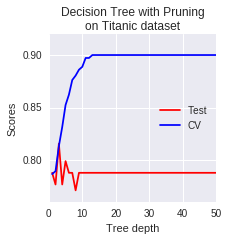

In [11]:
loadData('titanic')
plt.figure(figsize=(3, 3))
mean_scores = []
test_scores = []

parameters['alpha'] = 0.001

for i,depth in enumerate(range(1,51)):
    g=ClassificationTree()    
    parameters['max_node_depth'] = depth
    g.train(data=X_train, data_type_dict=data_type_dict, parameters=parameters, prune='true')    
    
    cv_score = 1 - g.error()
    mean_scores.append(cv_score)  
    
    err = g.test(data=X_test)
    #print err
    test_score = 1 - err
    test_scores.append(test_score)    
    

plt.plot(range(1,51),test_scores,label='Test',color='r')
plt.plot(range(1,51),mean_scores,label='CV',color='b')
plt.xlabel('Tree depth')
plt.ylabel('Scores')
plt.legend(loc='best')
plt.title(genTitle('titanic'))

plt.show()

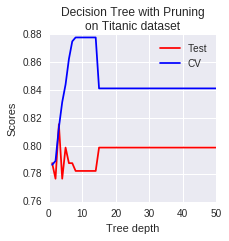

In [12]:
loadData('titanic')
plt.figure(figsize=(3, 3))
mean_scores = []
test_scores = []

parameters['alpha'] = 0.002

for i,depth in enumerate(range(1,51)):
    g=ClassificationTree()    
    parameters['max_node_depth'] = depth
    g.train(data=X_train, data_type_dict=data_type_dict, parameters=parameters, prune='true')    

    cv_score = 1 - g.error()
    mean_scores.append(cv_score)  
    
    err = g.test(data=X_test)
    #print err
    test_score = 1 - err
    test_scores.append(test_score)    
    
plt.plot(range(1,51),test_scores,label='Test',color='r')
plt.plot(range(1,51),mean_scores,label='CV',color='b')
plt.xlabel('Tree depth')
plt.ylabel('Scores')
plt.legend(loc='best')
plt.title(genTitle('titanic'))

plt.show()

In [10]:
accurate = 0
for i in range(len(X_test)):
    #print str(g.predict(X_test.iloc[i])) + ' <-> ' + str(imputed_DF.iloc[i]['Survived'])
    if i == 0:
        print type(y_test[i])
        print type(g.predict(X_test.iloc[i]))
        print type(X_test.iloc[i]['Survived'])

    if i < 10:
        print g.predict(X_test.iloc[i])
        print X_test.iloc[i]['Survived']

    if g.predict(X_test.iloc[i]) == X_test.iloc[i]['Survived']:
        accurate = accurate + 1

print accurate / ( len(X_test) * 1.0)

<type 'numpy.int64'>
<type 'numpy.float64'>
<type 'numpy.float64'>
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
1.0
1.0
0.793296089385
